# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [2]:
torch.__version__

'2.2.1+cu121'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from src.dgd.latent import RepresentationLayer
from src.dgd.latent import GaussianMixture
from src.dgd.nn import NB_Module

# get the new stuff
from src.utils.helpers import set_seed
from src.model.decoder import Decoder
from src.data.dataset import GeneExpressionDataset
# from src.engine.train import train_dgd

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 0
set_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cuda


# Load Data

In [5]:
# get gtex data just for testing

# uncomment to download the data
# !wget https://zenodo.org/record/7828660/files/gtex_with_cancer.csv.gz

gtex_raw = pd.read_table("data/gtex_with_cancer.csv.gz",sep='\t')
gtex_raw.head()

,ENSG00000177374.12,ENSG00000177707.10,ENSG00000225950.8,ENSG00000120526.10,ENSG00000164070.11,ENSG00000196663.15,ENSG00000148200.16,ENSG00000138755.5,ENSG00000204262.11,ENSG00000169618.6,...,ENSG00000167196.13,ENSG00000090905.18,ENSG00000119844.15,ENSG00000196152.10,ENSG00000185024.16,ENSG00000166170.9,ENSG00000198026.7,ENSG00000175970.10,ENSG00000213780.10,tissue
0,226787,77871,0,198267,72174,163235,9013,58467,343201,1104,...,83893,386315,128187,18552,164687,272994,217936,183796,100360,Adipose - Subcutaneous
1,889415,291912,296,125298,153665,193285,15275,27044,1504785,4590,...,111874,809856,238313,29292,317344,252189,330179,164379,150144,Adipose - Subcutaneous
2,344838,303004,0,75094,57021,155177,7878,593,628205,472,...,75320,412007,157403,21848,159849,266391,175808,119655,66478,Adipose - Subcutaneous
3,306402,124189,309,47470,40676,119022,3568,152,676679,13064,...,57464,361948,93965,11706,153276,273299,115782,150893,105214,Adipose - Visceral (Omentum)
4,478036,153432,211,169526,67231,165061,8517,5854,663403,395,...,114724,543113,205176,24213,258205,335637,278530,141132,180491,Adipose - Subcutaneous


In [6]:
# make data split for train and validation sets
out_dim = gtex_raw.shape[1]-1
# shuffle the data
gtex_raw = gtex_raw.sample(frac=1, random_state=seed)

# make the annotation a bit simpler here
tissue_classes_raw = gtex_raw.iloc[:,-1]
# make broader tissue classes: either take the first word, or "carcinoma" if it's in the string
tissue_classes = gtex_raw.iloc[:,-1].apply(lambda x: x.split()[0] if "carcinoma" not in x else "carcinoma")#.unique()
# revert "Whole" to "Whole Blood" and "Fallopian" to "Fallopian Tube"
tissue_classes = tissue_classes.apply(lambda x: "Whole Blood" if x=="Whole" else x)
tissue_classes = tissue_classes.apply(lambda x: "Fallopian Tube" if x=="Fallopian" else x)
gtex_raw.iloc[:,-1] = tissue_classes

## Data Loader

In [7]:
# make data split for train and validation sets
train_ratio = 0.9
train_data = gtex_raw.iloc[:int(train_ratio*len(gtex_raw)),:]
test_data = gtex_raw.iloc[int(train_ratio*len(gtex_raw)):,:]

# define scaling for NB
# each sample gets a scaling factor
scaling_factors = torch.mean(torch.Tensor(train_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
test_scaling_factors = torch.mean(torch.Tensor(test_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)

# make data loaders
train_loader = torch.utils.data.DataLoader(GeneExpressionDataset(train_data),
                                          batch_size=256,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(GeneExpressionDataset(test_data),
                                          batch_size=256,
                                          shuffle=True)

In [8]:
print(train_data.shape)
print(test_data.shape)
print(out_dim)

(23528, 5001)
(2615, 5001)
5000


In [9]:
for x, lib, index in train_loader:
    print(x.shape)
    print(lib.shape)
    print(lib)
    print(index.shape)
    print(index)
    break

torch.Size([256, 5000])
torch.Size([256])
tensor([126559.9766, 302139.2500, 267142.9062, 319089.0625,  61408.2305,
        361099.5312, 256545.6406, 287764.6875, 249298.8906, 228936.3906,
        195155.4844, 335524.2188, 225245.5156, 284696.1562, 190013.6094,
        222219.4219, 309948.8750, 323483.7188, 289212.9375, 201582.8125,
        185053.4375, 217281.2500, 114100.8359, 208068.3438, 536487.8750,
        404134.1562, 279302.8750, 267998.9062, 198021.7812, 288039.4375,
        433085.4375,  78795.7969, 185252.6406, 333260.0625, 208937.0469,
        260120.0938, 114203.1250, 200896.2188, 192767.5938, 365536.6875,
        154587.6406, 269306.2500, 252860.1562, 247656.1875, 335643.6250,
        214421.7656, 388120.2188, 495330.5625, 190670.2500, 177862.2344,
        245541.4219, 211633.8750, 310698.1562, 320868.0938, 215830.2188,
        279433.9375,  89116.0859, 236417.2344, 158848.4531, 345122.9062,
        283354.7812, 353993.4062, 214598.5625, 316368.6562, 310190.7188,
        2

In [10]:
n_tissues = len(gtex_raw["tissue"].unique())
n_tissues # bit too high with cancer types
n_tissues = 30

In [11]:
# hyperparameters
latent_dim = 20
hidden_dims = [128, 128, 128]
reduction_type = "sum" # output loss reduction

# Decoder Setup

In [12]:
# decoder setup

# set up an output module for the expression data
gex_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], out_dim)
    )
output_gex_layer = NB_Module(gex_out_fc, out_dim, scaling_type="mean")
output_gex_layer.n_features = out_dim

# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_gex_layer]).to(device)

# Specific code (DGD collection and training loop) as examples

Can be changed depending on the model, I assume

## DGD Class

In [13]:
# combine everything in one class (if desired)

class DGD(nn.Module):
    def __init__(self,decoder,n_mix,rep_dim,gmm_spec={}):
        super(DGD, self).__init__()
        self.decoder=decoder
        self.rep_dim = rep_dim      # Dimension of representation

        self.gmm=GaussianMixture(n_mix,rep_dim,**gmm_spec)
        self.train_rep=None
        self.val_rep=None
        self.test_rep=None

    def forward(self,z):
        return self.decoder(z)

    def loss(self,z,y,target,scale,gmm_loss=True,reduction="sum"):
        self.dec_loss = self.decoder.loss(y,target,scale,reduction=reduction)
        if gmm_loss:
            self.gmm_loss = self.gmm(z)
            if reduction=="mean":
                self.gmm_loss = self.gmm_loss.mean()
            elif reduction=="sum":
                self.gmm_loss = self.gmm_loss.sum()
            return self.dec_loss, self.gmm_loss
        else:
            return self.dec_loss, None
    
    def forward_and_loss(self,z,target,scale,gmm_loss=True,reduction="sum"):
        y = self.decoder(z)
        return self.loss(z,y,target,scale,gmm_loss,reduction)
    
    def get_representations(self, type="train"):
        if type=="train":
            return self.train_rep.z.detach().cpu().numpy()
        elif type=="val":
            return self.val_rep.z.detach().cpu().numpy()
        elif type=="test":
            return self.test_rep.z.detach().cpu().numpy()
    
    def get_gmm_means(self):
        return self.gmm.mean.detach().cpu().numpy()
    
    def get_latent_space_values(self, rep_type="train", n_samples=1000):
        # get representations
        if rep_type=="train":
            rep = self.train_rep.z.clone().detach().cpu().numpy()
        elif rep_type=="val":
            rep = self.val_rep.z.clone().detach().cpu().numpy()
        elif rep_type=="test":
            rep = self.test_rep.z.clone().detach().cpu().numpy()
        
        # get gmm means
        gmm_means = self.gmm.mean.clone().detach().cpu().numpy()

        # get some gmm samples
        gmm_samples = self.gmm.sample(n_samples).detach().cpu().numpy()

        return rep, gmm_means, gmm_samples

## Plotting Function

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_latent_space(rep, means, samples, labels, epoch):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1","PC2"])
    df["type"] = "rep"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1","PC2"])
    df_temp["type"] = "samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1","PC2"])
    df_temp["type"] = "means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    # add spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[1,1,10], alpha=0.8, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title("E"+str(epoch)+": Latent space (by type)")
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    sns.scatterplot(data=df[df["type"] == "rep"], x="PC1", y="PC2", hue="label", s=1, alpha=0.8, ax=ax[1])
    ax[1].set_title("E"+str(epoch)+": Latent space (by label)")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)

    plt.show()

## Training Function

In [15]:
# write a minimal training function

def train_dgd(dgd, train_loader, validation_loader, device, learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},weight_decay=0.,nepochs=100,pr=1,plot=10,reduction_type="sum"):
    if reduction_type == "sum":
        tlen=len(train_loader.dataset)*dgd.decoder.n_out_features
        tlen_gmm=len(train_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
        vlen=len(validation_loader.dataset)*dgd.decoder.n_out_features
        vlen_gmm=len(validation_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
    else:
        tlen=len(train_loader)
        tlen_gmm=len(train_loader)
        vlen=len(validation_loader)
        vlen_gmm=len(validation_loader)
    
    Ntrain=len(train_loader.dataset)
    Nvalidation=len(validation_loader.dataset)
    if dgd.train_rep is None:
        dgd.train_rep = RepresentationLayer(dgd.rep_dim,Ntrain).to(device)
    Nvalidation=len(validation_loader.dataset)
    if dgd.val_rep is None:
        dgd.val_rep = RepresentationLayer(dgd.rep_dim,Nvalidation).to(device)

    dec_optimizer = torch.optim.AdamW(dgd.decoder.parameters(), lr=learning_rates['dec'])
    gmm_optimizer = torch.optim.AdamW(dgd.gmm.parameters(), lr=learning_rates['gmm'])
    train_rep_optimizer = torch.optim.AdamW(dgd.train_rep.parameters(), lr=learning_rates['rep'])
    val_rep_optimizer = torch.optim.AdamW(dgd.val_rep.parameters(), lr=learning_rates['rep'])

    loss_tab = {"Epoch":[],"Train recon":[],"Test recon":[],
                "GMM train":[],"GMM test":[]}
    best_loss=1.e20
    gmm_loss=True

    for epoch in range(nepochs):
        loss_tab["Epoch"].append(epoch)
        loss_tab["Train recon"].append(0.)
        loss_tab["GMM train"].append(0.)
        train_rep_optimizer.zero_grad()
        dgd.train()
        for x, lib, index in train_loader:
            dec_optimizer.zero_grad()
            if gmm_loss: gmm_optimizer.zero_grad()
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.train_rep(index),[x.to(device)],[lib.unsqueeze(1).to(device)],
                                        gmm_loss=gmm_loss,reduction=reduction_type)
            loss_tab["Train recon"][-1] += recon_loss.item()
            loss_tab["GMM train"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
            dec_optimizer.step()
            if gmm_loss: gmm_optimizer.step()
            #return None
        train_rep_optimizer.step()

        loss_tab["Train recon"][-1] /= tlen
        loss_tab["GMM train"][-1] /= tlen_gmm

        # Validation data
        loss_tab["Test recon"].append(0.)
        loss_tab["GMM test"].append(0.)
        val_rep_optimizer.zero_grad()
        dgd.eval()
        for x, lib, index in validation_loader:
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.val_rep(index),[x.to(device)],[lib.unsqueeze(1).to(device)],
                                        gmm_loss=gmm_loss,reduction=reduction_type)
            loss_tab["Test recon"][-1] += recon_loss.item()
            loss_tab["GMM test"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
        val_rep_optimizer.step()

        loss_tab["Test recon"][-1] /= vlen
        loss_tab["GMM test"][-1] /= vlen_gmm

        if pr>=0 and (epoch)%pr==0:
            print(epoch, loss_tab["Train recon"][-1], loss_tab["Test recon"][-1])
        if plot>=0 and (epoch)%plot==0:
            plot_latent_space(*dgd.get_latent_space_values("train",1000), train_loader.dataset.label, epoch)
    
    return loss_tab

# Train and Test the model

## Params and DGD

In [16]:
# init a DGD model

gmm_mean_scale = 5.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

## Training loop

0 13.582346183270996 12.93896137667304


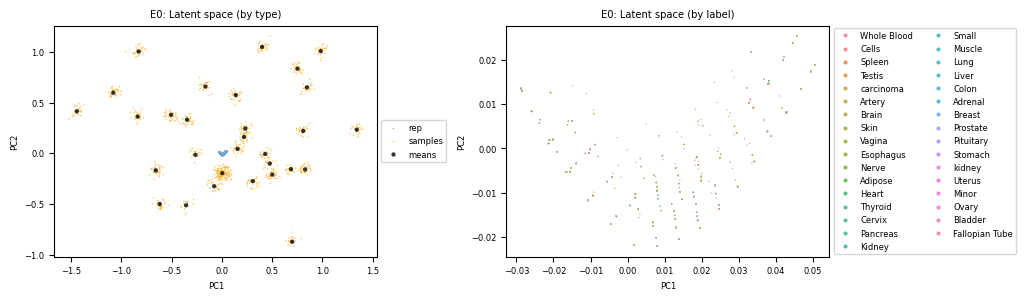

100 11.166136399183952 11.174238355640535


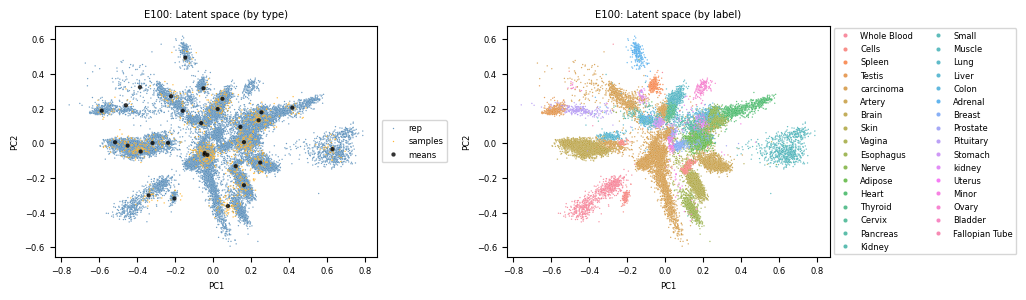

200 11.075332973478409 11.084885239005736


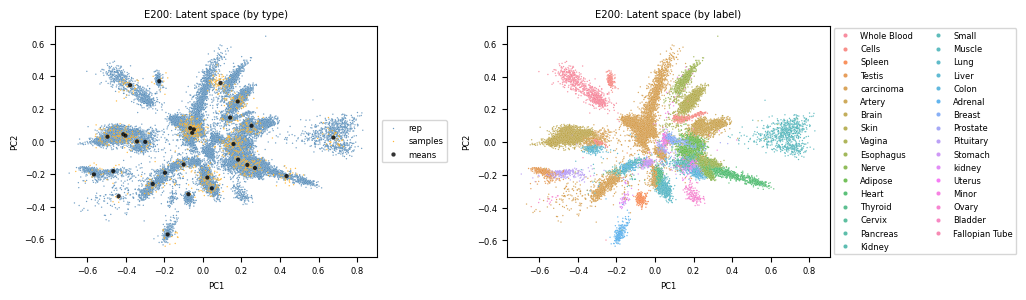

300 11.054043378102687 11.065358183556405


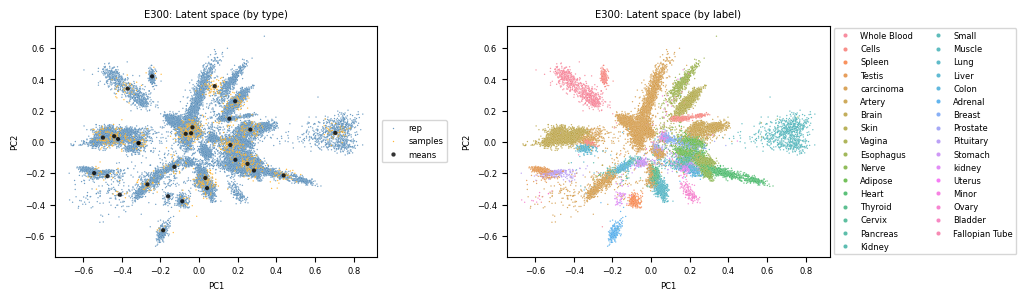

400 11.04347480448827 11.054690764818355


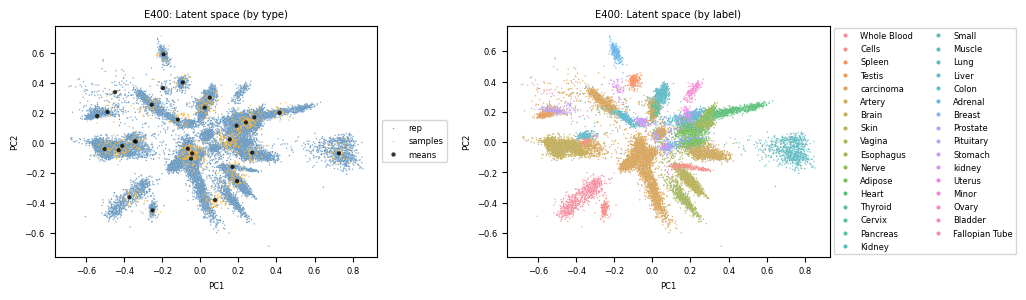

In [17]:
# train for 10 epochs and plot learning curves
n_epochs = 500
pr = 100 # how often to print
plot = 100

loss_tab = train_dgd(
    dgd, train_loader, test_loader, device, 
    learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},
    weight_decay=0.,nepochs=n_epochs,pr=pr,plot=plot,reduction_type=reduction_type
    )
# stuff is running but I have to check the loss normalization for printing and plotting, they seem a bit large

# Plotting

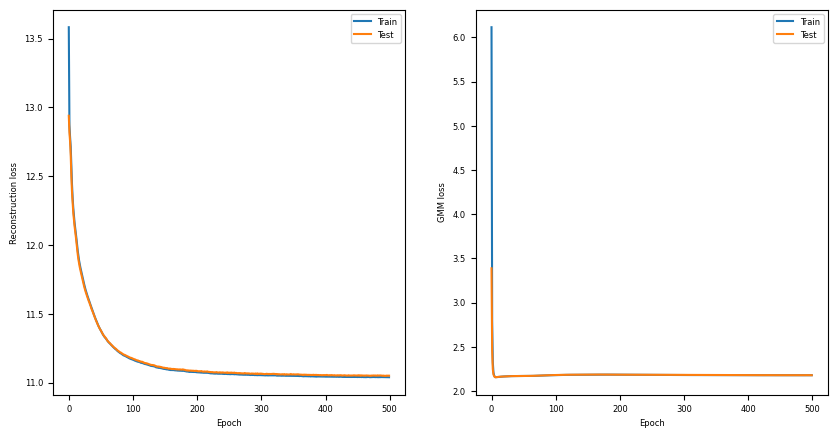

In [18]:
import matplotlib.pyplot as plt
# make 2 subplots with recon and gmm loss curves

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_tab["Epoch"],loss_tab["Train recon"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["Test recon"],label="Test")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss_tab["Epoch"],loss_tab["GMM train"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["GMM test"],label="Test")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")
plt.legend()
plt.show()

In [19]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (out_modules): ModuleList(
      (0): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=128, out_features=5000, bias=True)
        )
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
)

In [20]:
torch.save(dgd.state_dict(), "saved_model/11032024_gtex.pth")